### Uses all anterior brand
### Transfer learning = resnet34

Example followed: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [55]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from statistics import mean 
from torchvision.utils import make_grid
import time
import sklearn.metrics
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report
import seaborn as sn  # for heatmaps
import scipy.stats as st

plt.ion()   # interactive mode

In [56]:
# Reading train, test, val sets
train_set = pd.read_csv("/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/Train_full_data.csv")
train_set['brand']=train_set['Label']
train_set.loc[train_set['Label'] == 0.0, 'brand'] = 'atlantis'
train_set.loc[train_set['Label'] == 1.0, 'brand'] = 'archon'
train_set.loc[train_set['Label'] == 2.0, 'brand'] = 'maxan'
train_set.loc[train_set['Label'] == 3.0, 'brand'] = 'helix_zevo'

val_set = pd.read_csv("/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/Val_full_data.csv")
val_set['brand']=val_set['Label']
val_set.loc[val_set['Label'] == 0.0, 'brand'] = 'atlantis'
val_set.loc[val_set['Label'] == 1.0, 'brand'] = 'archon'
val_set.loc[val_set['Label'] == 2.0, 'brand'] = 'maxan'
val_set.loc[val_set['Label'] == 3.0, 'brand'] = 'helix_zevo'

test_set = pd.read_csv("/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/Test_full_data.csv")
test_set['brand']=test_set['Label']
test_set.loc[test_set['Label'] == 0.0, 'brand'] = 'atlantis'
test_set.loc[test_set['Label'] == 1.0, 'brand'] = 'archon'
test_set.loc[test_set['Label'] == 2.0, 'brand'] = 'maxan'
test_set.loc[test_set['Label'] == 3.0, 'brand'] = 'helix_zevo'

# Train
X_train = train_set['filepath']
Y_train = train_set['Label']
print("Training Set")
print(30*"-")
print(f'Records:\t{X_train.shape[0]}')
print("Brand Breakdown\n")
print(train_set['brand'].value_counts())

# Val
X_val = val_set['filepath']
Y_val = val_set['Label']
print("\nValidation Set")
print(30*"-")
print(f'Records:\t{X_val.shape[0]}')
print("Brand Breakdown\n")
print(val_set['brand'].value_counts())

# Test
X_test = test_set['filepath']
Y_test = test_set['Label']
print("\nTest Set\n")
print(30*"-")
print(f'Records:\t{X_test.shape[0]}')
print("Brand Breakdown")
print(test_set['brand'].value_counts())

Training Set
------------------------------
Records:	1045
Brand Breakdown

atlantis      669
archon        237
maxan         134
helix_zevo      5
Name: brand, dtype: int64

Validation Set
------------------------------
Records:	249
Brand Breakdown

atlantis      149
maxan          45
archon         45
helix_zevo     10
Name: brand, dtype: int64

Test Set

------------------------------
Records:	349
Brand Breakdown
atlantis      233
archon         83
maxan          21
helix_zevo     12
Name: brand, dtype: int64


In [57]:
pwd

'/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior'

## Estimate mean and std of training data for normalization

In [58]:
# Just normalization for validation
aug_transform = {
    'train': transforms.Compose([
        #transforms.
        #transforms.RandomResizedCrop(224),
        transforms.Resize((256,256)),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        #transforms.Normalize([avg_pop_mean, avg_pop_mean, avg_pop_mean], [avg_pop_std0, avg_pop_std0, avg_pop_std0])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        #transforms.Normalize([avg_pop_mean, avg_pop_mean, avg_pop_mean], [avg_pop_std0, avg_pop_std0, avg_pop_std0])
    ]),

    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        #transforms.Normalize([avg_pop_mean, avg_pop_mean, avg_pop_mean], [avg_pop_std0, avg_pop_std0, avg_pop_std0])
    ])
}


data_dir = '/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          aug_transform[x]) for x in ['train', 'val','test']}
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=1, shuffle=True, num_workers =0)

pop_mean = []
pop_std0 = []

for i in range(len(train_loader.dataset.imgs)):
    inputs, classes = next(iter(train_loader))
    #display(plt.imshow(inputs[0][0]))
    batch_mean = inputs[0][0].mean().item()
    batch_std0 = inputs[0][0].std().item()
    pop_mean.append(batch_mean)
    pop_std0.append(batch_std0)
    i += 1
    #print(mean)

def Average(lst): 

    return mean(lst) 
avg_pop_mean = Average(pop_mean)
avg_pop_std0 =Average(pop_std0)
print(Average(pop_mean))
print(Average(pop_std0))

print(f'Avg mean of training data: {avg_pop_mean}')
print(f'Avg std of training data: {avg_pop_std0}')

0.3592673513113252
0.25157362404292805
Avg mean of training data: 0.3592673513113252
Avg std of training data: 0.25157362404292805


## Load Data

In [59]:
# Augmentation pipeline
aug_transform = {
    'train': transforms.Compose([
        transforms.Resize((256,256)), # resize image to 256x256
        transforms.RandomHorizontalFlip(p=0.5), # horizontal flip
        transforms.RandomVerticalFlip(p=0.5), # vertical flip
        transforms.RandomRotation(degrees=(-15,15)),
        transforms.ToTensor(),
        #transforms.Normalize([avg_pop_mean, avg_pop_mean, avg_pop_mean], [avg_pop_std0, avg_pop_std0, avg_pop_std0]) # normalize images
        transforms.Normalize([0, 0, 0], [1, 1, 1])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)), # resize image to 256x256
        transforms.ToTensor(),
        #transforms.Normalize([avg_pop_mean, avg_pop_mean, avg_pop_mean], [avg_pop_std0, avg_pop_std0, avg_pop_std0])
        transforms.Normalize([0, 0, 0], [1, 1, 1])
    ]),

    'test': transforms.Compose([
        transforms.Resize((256, 256)), # resize image to 256x256
        transforms.ToTensor(),
        #transforms.Normalize([avg_pop_mean, avg_pop_mean, avg_pop_mean], [avg_pop_std0, avg_pop_std0, avg_pop_std0])
        transforms.Normalize([0, 0, 0], [1, 1, 1])
    ])
}

data_dir = '/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          aug_transform[x]) for x in ['train', 'val','test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [60]:
class_names
image_datasets['test'].classes

['archon', 'atlantis', 'helix_zevo', 'maxan']

## View a batch of images

Label: [    1     1     1     3     1     1     0     1     3     1]
Class:  atlantis atlantis atlantis maxan atlantis atlantis archon atlantis maxan atlantis


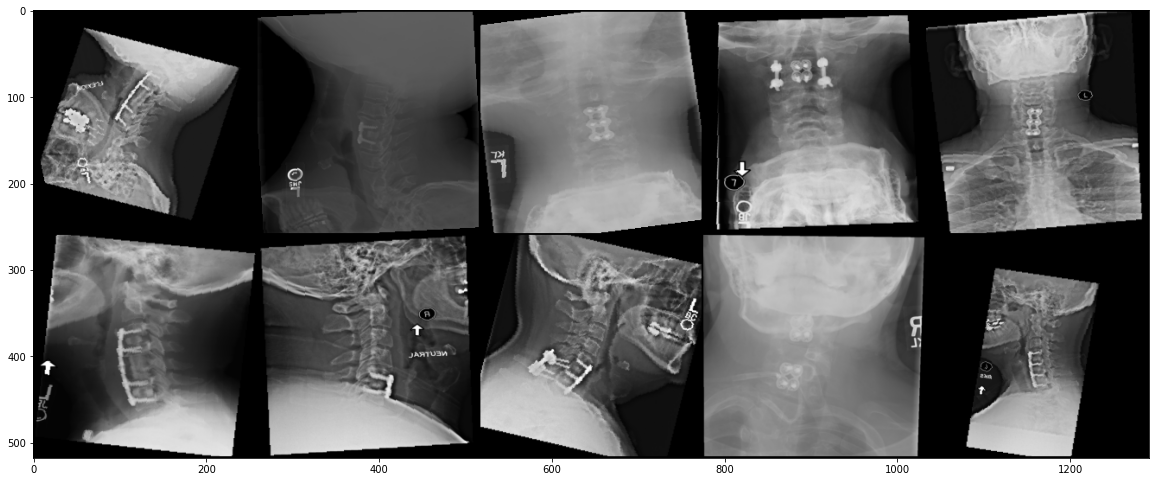

In [61]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in dataloaders['train']: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Model Training

In [62]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses = []
    val_losses = []
    train_correct = []
    val_correct = []
    
    for epoch in range(num_epochs):
        trn_corr = 0
        tst_corr = 0
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_correct.append(epoch_acc.item())
            elif phase == 'val':
                val_losses.append(epoch_loss)
                val_correct.append(epoch_acc.item())
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_correct,val_correct

## Hyperparameter Tuning

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device ='cpu'
lr1_list = [1e-7,1e-6]
lr2_list = [1e-1, 1e-2]
epochlist =[6, 10, 25]


# CREATING CRITEREON LIST
# Weightings for nlloss
value_counts_ = Y_train.value_counts().sort_index()
no_of_cats = len(value_counts_)
weightings = value_counts_.sum()/(value_counts_*no_of_cats).values
weightings = torch.FloatTensor(weightings) 
criterion_weighted = nn.NLLLoss(weight = weightings).to(device)
criterion_notweighted = nn.CrossEntropyLoss()

criterion_list = [criterion_weighted, criterion_notweighted]

# CREATING MODEL LIST
# Resnet34
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_34 = model_ft.to(device)

# Resnet34
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_50 = model_ft.to(device)

modellist = [model_34]

def metrics_function(y_predicted, y_probs, y_true):
    '''
    This function takes an input of predictions and true values and returns weighted precision, recall, f1 scores,
    and AUC scores. 
    Inputs:
        y_predicted: NumPy array of shape (n_samples,) which contains predictions of categories
        y_probs: NumPy array of shape (n_samples, n_classes) which contains probabilities for each class
        y_true: NumPy array of shape (n_samples,) which contains actual labels for samples
    Outputs:
        f1_score: Weighted F1-score
        precision: Weighted Precision score
        recall: Weighted recall score
        auc: Weighted AUC score calculated using One-Versus-Rest Approach
        confusion_matrix: Confusion Matrix
    '''
    import sklearn.metrics
    from sklearn.preprocessing import OneHotEncoder
    import numpy as np
    
    params = {
        'y_true': y_true,
        'y_pred': y_predicted,
        'average': 'weighted'
    }
    f1_score = sklearn.metrics.f1_score(**params)
    precision = sklearn.metrics.precision_score(**params)
    recall = sklearn.metrics.recall_score(**params)
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true = y_true, y_pred = y_predicted)
    
    encoder = OneHotEncoder()
    y_encoded = encoder.fit_transform(np.array(y_true).reshape(-1,1))
    auc = sklearn.metrics.roc_auc_score(y_true = y_encoded.toarray(), y_score = y_probs, average='weighted', multi_class = 'ovr')
    
    return f1_score, precision, recall, auc, confusion_matrix

hypertuning = pd.DataFrame(columns =['lr1','lr2','epochs', 'criterion', 'model','f1'])

## TUNING 

# model
for model_ft in modellist:
    # learning rate for model head
    for lr1 in lr1_list:

        # learning rate for model tail
        for lr2 in lr2_list:

            optimizer_ft = torch.optim.Adam([{'params': list(model_ft.parameters())[:-1], 'lr': lr1},{'params': list(model_ft.parameters())[-1], 'lr':lr2}])

            # epochs
            for epochs in epochlist:

                # criterion
                for criterion in criterion_list:
                    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.003, steps_per_epoch=len(dataloaders['train']), epochs=10)
                    model_ft,train_loss,val_loss, train_correct, val_correct = train_model(model_ft, criterion, optimizer_ft, scheduler,num_epochs=epochs)

                    # Calculate weighted f1
                    dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=False)

                    y_test_list = []
                    pred_list = []
                    y_score_list = []
                    with torch.no_grad():
                        correct = 0
                        for X_test, y_test in dataloaders['val']:
                            X_test = X_test.to(device)
                            y_test = y_test.to(device)
                            y_val = model_ft(X_test)
                            y_val = y_val.to(device)
                            y_test_list.append(y_test.item())
                            y_score_list.append(y_val.to('cpu').numpy())
                            predicted = torch.max(y_val,1)[1]
                            pred_list.append(predicted.item())
                            correct += (predicted == y_test).sum()

                    y_test_list= np.asarray(y_test_list)
                    pred_list = np.asarray(pred_list)
                    y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
                    y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])

                    f1_score, precision, recall, auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)

                    # Saving hyperparameters and performance
                    rows = [[lr1,lr2, epochs, criterion, model_ft, f1_score]]
                    for row in rows:
                        hypertuning.loc[len(hypertuning)] = row

        
hypertuning.head()

Epoch 0/5
----------
train Loss: -3.5087 Acc: 0.3519
val Loss: -5.3411 Acc: 0.4779

Epoch 1/5
----------
train Loss: -13.0346 Acc: 0.4660
val Loss: -5.2927 Acc: 0.5422

Epoch 2/5
----------
train Loss: -29.2971 Acc: 0.5264
val Loss: -21.0594 Acc: 0.5542

Epoch 3/5
----------
train Loss: -40.0135 Acc: 0.5542
val Loss: -71.3479 Acc: 0.4578

Epoch 4/5
----------
train Loss: -62.1753 Acc: 0.5599
val Loss: -87.9637 Acc: 0.4940

Epoch 5/5
----------
train Loss: -87.6629 Acc: 0.6021
val Loss: -88.5150 Acc: 0.5622

Training complete in 4m 34s
Best val Acc: 0.562249


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/5
----------
train Loss: 5.1265 Acc: 0.3490
val Loss: 2.1488 Acc: 0.4538

Epoch 1/5
----------
train Loss: 1.0513 Acc: 0.5992
val Loss: 2.1983 Acc: 0.6064

Epoch 2/5
----------
train Loss: 0.9182 Acc: 0.6433
val Loss: 1.8508 Acc: 0.6024

Epoch 3/5
----------
train Loss: 0.8285 Acc: 0.6539
val Loss: 1.3929 Acc: 0.6064

Epoch 4/5
----------
train Loss: 0.8344 Acc: 0.6577
val Loss: 1.7026 Acc: 0.5863

Epoch 5/5
----------
train Loss: 0.7944 Acc: 0.6769
val Loss: 1.9395 Acc: 0.5823

Training complete in 4m 46s
Best val Acc: 0.606426


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/9
----------
train Loss: -89.1033 Acc: 0.5849
val Loss: -41.1537 Acc: 0.5582

Epoch 1/9
----------
train Loss: -108.5612 Acc: 0.5532
val Loss: -118.6818 Acc: 0.4900

Epoch 2/9
----------
train Loss: -158.9778 Acc: 0.5781
val Loss: -15.0553 Acc: 0.6104

Epoch 3/9
----------
train Loss: -237.0436 Acc: 0.5877
val Loss: -50.1774 Acc: 0.5060

Epoch 4/9
----------
train Loss: -265.4426 Acc: 0.5321
val Loss: -319.7680 Acc: 0.4096

Epoch 5/9
----------
train Loss: -314.2999 Acc: 0.5024
val Loss: -77.1962 Acc: 0.5422

Epoch 6/9
----------
train Loss: -365.0454 Acc: 0.5206
val Loss: -36.1610 Acc: 0.5944

Epoch 7/9
----------
train Loss: -414.8889 Acc: 0.5014
val Loss: -84.8236 Acc: 0.5100

Epoch 8/9
----------
train Loss: -503.2726 Acc: 0.4966
val Loss: -218.7162 Acc: 0.4578

Epoch 9/9
----------
train Loss: -555.4324 Acc: 0.5129
val Loss: -80.6953 Acc: 0.4779

Training complete in 7m 55s
Best val Acc: 0.610442


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/9
----------
train Loss: 7.8547 Acc: 0.6405
val Loss: 12.5317 Acc: 0.5944

Epoch 1/9
----------
train Loss: 4.9282 Acc: 0.6405
val Loss: 3.8350 Acc: 0.6265

Epoch 2/9
----------
train Loss: 2.1010 Acc: 0.6184
val Loss: 12.0075 Acc: 0.6345

Epoch 3/9
----------
train Loss: 1.0131 Acc: 0.6433
val Loss: 6.2083 Acc: 0.6265

Epoch 4/9
----------
train Loss: 0.8285 Acc: 0.6721
val Loss: 6.2012 Acc: 0.6265

Epoch 5/9
----------
train Loss: 0.7761 Acc: 0.6932
val Loss: 3.6173 Acc: 0.6345

Epoch 6/9
----------
train Loss: 0.7987 Acc: 0.6711
val Loss: 7.4016 Acc: 0.6586

Epoch 7/9
----------
train Loss: 0.7751 Acc: 0.6874
val Loss: 3.3659 Acc: 0.6345

Epoch 8/9
----------
train Loss: 0.7626 Acc: 0.6922
val Loss: 6.5303 Acc: 0.6466

Epoch 9/9
----------
train Loss: 0.7319 Acc: 0.7028
val Loss: 3.6376 Acc: 0.6506

Training complete in 7m 55s
Best val Acc: 0.658635


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/24
----------
train Loss: -203.0612 Acc: 0.6328
val Loss: -35.4210 Acc: 0.6104

Epoch 1/24
----------
train Loss: -245.7593 Acc: 0.5992
val Loss: -72.1916 Acc: 0.6185

Epoch 2/24
----------
train Loss: -297.0386 Acc: 0.5609
val Loss: -251.0119 Acc: 0.4699

Epoch 3/24
----------
train Loss: -372.8193 Acc: 0.5820
val Loss: -71.4796 Acc: 0.5582

Epoch 4/24
----------
train Loss: -389.2372 Acc: 0.5360
val Loss: -223.5640 Acc: 0.4096

Epoch 5/24
----------
train Loss: -480.5434 Acc: 0.5158
val Loss: -137.5997 Acc: 0.5221

Epoch 6/24
----------
train Loss: -503.0797 Acc: 0.5417
val Loss: -493.6961 Acc: 0.4257

Epoch 7/24
----------
train Loss: -614.7192 Acc: 0.5676
val Loss: -89.7912 Acc: 0.5020

Epoch 8/24
----------
train Loss: -661.4098 Acc: 0.5225
val Loss: -217.4491 Acc: 0.5020

Epoch 9/24
----------
train Loss: -715.7564 Acc: 0.5014
val Loss: -152.3147 Acc: 0.4940

Epoch 10/24
----------
train Loss: -799.9978 Acc: 0.4813
val Loss: -95.5087 Acc: 0.5703

Epoch 11/24
----------
tr

/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/24
----------
train Loss: 5.6758 Acc: 0.6174
val Loss: 13.0489 Acc: 0.6145

Epoch 1/24
----------
train Loss: 2.5157 Acc: 0.6769
val Loss: 6.0348 Acc: 0.6185

Epoch 2/24
----------
train Loss: 0.9649 Acc: 0.6616
val Loss: 9.1040 Acc: 0.6305

Epoch 3/24
----------
train Loss: 0.8725 Acc: 0.6807
val Loss: 7.5101 Acc: 0.6305

Epoch 4/24
----------
train Loss: 0.8484 Acc: 0.6922
val Loss: 7.9423 Acc: 0.6345

Epoch 5/24
----------
train Loss: 0.7729 Acc: 0.6846
val Loss: 6.4585 Acc: 0.6225

Epoch 6/24
----------
train Loss: 0.7999 Acc: 0.6903
val Loss: 5.7564 Acc: 0.6225

Epoch 7/24
----------
train Loss: 0.7654 Acc: 0.6951
val Loss: 8.3959 Acc: 0.6265

Epoch 8/24
----------
train Loss: 0.8070 Acc: 0.6865
val Loss: 10.3037 Acc: 0.6386

Epoch 9/24
----------
train Loss: 0.7551 Acc: 0.7037
val Loss: 6.2842 Acc: 0.6305

Epoch 10/24
----------
train Loss: 0.7605 Acc: 0.6942
val Loss: 7.5771 Acc: 0.6225

Epoch 11/24
----------
train Loss: 0.7575 Acc: 0.6884
val Loss: 7.7778 Acc: 0.6185



/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/5
----------
train Loss: -324.5147 Acc: 0.6500
val Loss: -90.1649 Acc: 0.6185

Epoch 1/5
----------
train Loss: -359.3613 Acc: 0.6376
val Loss: -109.1612 Acc: 0.6426

Epoch 2/5
----------
train Loss: -464.8592 Acc: 0.6337
val Loss: -54.2894 Acc: 0.6345

Epoch 3/5
----------
train Loss: -454.3245 Acc: 0.6242
val Loss: -207.9092 Acc: 0.4900

Epoch 4/5
----------
train Loss: -555.5219 Acc: 0.6012
val Loss: -364.5264 Acc: 0.5100

Epoch 5/5
----------
train Loss: -530.5880 Acc: 0.6050
val Loss: -160.1078 Acc: 0.5743

Training complete in 7m 20s
Best val Acc: 0.642570


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/5
----------
train Loss: 1.8626 Acc: 0.6644
val Loss: 7.9134 Acc: 0.5984

Epoch 1/5
----------
train Loss: 0.8193 Acc: 0.6711
val Loss: 7.2487 Acc: 0.6426

Epoch 2/5
----------
train Loss: 0.8667 Acc: 0.6961
val Loss: 9.4622 Acc: 0.6104

Epoch 3/5
----------
train Loss: 1.0207 Acc: 0.6663
val Loss: 8.6074 Acc: 0.6506

Epoch 4/5
----------
train Loss: 0.7733 Acc: 0.6759
val Loss: 2.8427 Acc: 0.6506

Epoch 5/5
----------
train Loss: 0.7461 Acc: 0.6922
val Loss: 4.0831 Acc: 0.6426

Training complete in 7m 19s
Best val Acc: 0.650602


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/9
----------
train Loss: -353.7635 Acc: 0.6510
val Loss: -166.0579 Acc: 0.6064

Epoch 1/9
----------
train Loss: -473.2276 Acc: 0.6491
val Loss: -65.1327 Acc: 0.5542

Epoch 2/9
----------
train Loss: -539.4302 Acc: 0.5935
val Loss: -53.5862 Acc: 0.5944

Epoch 3/9
----------
train Loss: -552.2104 Acc: 0.5647
val Loss: -285.6398 Acc: 0.4940

Epoch 4/9
----------
train Loss: -615.7063 Acc: 0.5494
val Loss: -158.0886 Acc: 0.5060

Epoch 5/9
----------
train Loss: -603.3832 Acc: 0.5532
val Loss: -170.7175 Acc: 0.5743

Epoch 6/9
----------
train Loss: -662.9909 Acc: 0.5590
val Loss: -257.4814 Acc: 0.5141

Epoch 7/9
----------
train Loss: -814.2512 Acc: 0.5034
val Loss: -234.2742 Acc: 0.4056

Epoch 8/9
----------
train Loss: -877.3101 Acc: 0.4966
val Loss: -310.5974 Acc: 0.4578

Epoch 9/9
----------
train Loss: -898.5455 Acc: 0.4938
val Loss: -575.4364 Acc: 0.3896

Training complete in 12m 14s
Best val Acc: 0.606426


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/9
----------
train Loss: 1.1675 Acc: 0.6663
val Loss: 5.1161 Acc: 0.6024

Epoch 1/9
----------
train Loss: 0.8103 Acc: 0.6702
val Loss: 6.9691 Acc: 0.5944

Epoch 2/9
----------
train Loss: 0.8084 Acc: 0.6462
val Loss: 7.8065 Acc: 0.5904

Epoch 3/9
----------
train Loss: 0.7940 Acc: 0.6606
val Loss: 5.5249 Acc: 0.6064

Epoch 4/9
----------
train Loss: 0.7725 Acc: 0.6750
val Loss: 8.5341 Acc: 0.5984

Epoch 5/9
----------
train Loss: 0.7848 Acc: 0.6846
val Loss: 6.0250 Acc: 0.5984

Epoch 6/9
----------
train Loss: 0.7765 Acc: 0.6874
val Loss: 8.4688 Acc: 0.5984

Epoch 7/9
----------
train Loss: 0.8104 Acc: 0.6922
val Loss: 5.5663 Acc: 0.5984

Epoch 8/9
----------
train Loss: 0.7569 Acc: 0.6922
val Loss: 4.4530 Acc: 0.6185

Epoch 9/9
----------
train Loss: 0.7850 Acc: 0.6798
val Loss: 5.3920 Acc: 0.6265

Training complete in 12m 14s
Best val Acc: 0.626506


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/24
----------
train Loss: -425.9384 Acc: 0.6481
val Loss: -68.7071 Acc: 0.5984

Epoch 1/24
----------
train Loss: -456.8686 Acc: 0.5964
val Loss: -21.6708 Acc: 0.6104

Epoch 2/24
----------
train Loss: -564.8887 Acc: 0.5868
val Loss: -364.0097 Acc: 0.4538

Epoch 3/24
----------
train Loss: -566.6030 Acc: 0.5877
val Loss: -96.1820 Acc: 0.4940

Epoch 4/24
----------
train Loss: -698.3365 Acc: 0.5455
val Loss: -239.7569 Acc: 0.4940

Epoch 5/24
----------
train Loss: -720.8098 Acc: 0.5216
val Loss: -367.9008 Acc: 0.4940

Epoch 6/24
----------
train Loss: -839.7500 Acc: 0.5542
val Loss: -1465.2696 Acc: 0.3976

Epoch 7/24
----------
train Loss: -845.8502 Acc: 0.5446
val Loss: -343.4366 Acc: 0.4739

Epoch 8/24
----------
train Loss: -955.3634 Acc: 0.5053
val Loss: -285.9300 Acc: 0.4217

Epoch 9/24
----------
train Loss: -1069.7225 Acc: 0.5513
val Loss: -427.0226 Acc: 0.4418

Epoch 10/24
----------
train Loss: -1208.4737 Acc: 0.4813
val Loss: -295.1285 Acc: 0.4056

Epoch 11/24
--------

/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/24
----------
train Loss: 3.4788 Acc: 0.6309
val Loss: 7.4813 Acc: 0.5944

Epoch 1/24
----------
train Loss: 1.5739 Acc: 0.6731
val Loss: 7.6899 Acc: 0.6145

Epoch 2/24
----------
train Loss: 1.0123 Acc: 0.6817
val Loss: 4.9414 Acc: 0.6185

Epoch 3/24
----------
train Loss: 0.8114 Acc: 0.6807
val Loss: 8.7320 Acc: 0.5984

Epoch 4/24
----------
train Loss: 0.7864 Acc: 0.6913
val Loss: 4.4834 Acc: 0.6225

Epoch 5/24
----------
train Loss: 0.7886 Acc: 0.6846
val Loss: 11.9608 Acc: 0.5944

Epoch 6/24
----------
train Loss: 0.7766 Acc: 0.6913
val Loss: 9.3766 Acc: 0.6104

Epoch 7/24
----------
train Loss: 0.7727 Acc: 0.6836
val Loss: 7.6369 Acc: 0.6064

Epoch 8/24
----------
train Loss: 0.7685 Acc: 0.6855
val Loss: 5.4146 Acc: 0.6145

Epoch 9/24
----------
train Loss: 0.7503 Acc: 0.6961
val Loss: 3.1183 Acc: 0.6185

Epoch 10/24
----------
train Loss: 0.7439 Acc: 0.6999
val Loss: 4.2014 Acc: 0.6225

Epoch 11/24
----------
train Loss: 0.7423 Acc: 0.6913
val Loss: 7.4446 Acc: 0.5984

E

/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/5
----------
train Loss: -558.3823 Acc: 0.6405
val Loss: -25.9333 Acc: 0.6064

Epoch 1/5
----------
train Loss: -706.6805 Acc: 0.6500
val Loss: -54.5975 Acc: 0.5622

Epoch 2/5
----------
train Loss: -651.2304 Acc: 0.6059
val Loss: -365.2854 Acc: 0.5582

Epoch 3/5
----------
train Loss: -686.6483 Acc: 0.6021
val Loss: -124.5784 Acc: 0.6024

Epoch 4/5
----------
train Loss: -778.9882 Acc: 0.5896
val Loss: -86.3047 Acc: 0.5301

Epoch 5/5
----------
train Loss: -924.9235 Acc: 0.5849
val Loss: -268.5049 Acc: 0.5382

Training complete in 7m 20s
Best val Acc: 0.606426


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/5
----------
train Loss: 1.1990 Acc: 0.6568
val Loss: 1.3601 Acc: 0.6024

Epoch 1/5
----------
train Loss: 0.8527 Acc: 0.6683
val Loss: 1.3522 Acc: 0.5944

Epoch 2/5
----------
train Loss: 0.7792 Acc: 0.6702
val Loss: 1.1040 Acc: 0.5944

Epoch 3/5
----------
train Loss: 0.7725 Acc: 0.6932
val Loss: 1.2354 Acc: 0.5984

Epoch 4/5
----------
train Loss: 0.7708 Acc: 0.6874
val Loss: 1.2237 Acc: 0.6064

Epoch 5/5
----------
train Loss: 0.7745 Acc: 0.6798
val Loss: 1.5491 Acc: 0.6104

Training complete in 7m 20s
Best val Acc: 0.610442


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/9
----------
train Loss: -667.0234 Acc: 0.6520
val Loss: -668.6229 Acc: 0.3936

Epoch 1/9
----------
train Loss: -647.5253 Acc: 0.6021
val Loss: -62.7653 Acc: 0.5382

Epoch 2/9
----------
train Loss: -771.3296 Acc: 0.5781
val Loss: -1015.4881 Acc: 0.4297

Epoch 3/9
----------
train Loss: -784.1410 Acc: 0.5638
val Loss: -198.3140 Acc: 0.5301

Epoch 4/9
----------
train Loss: -914.8059 Acc: 0.5484
val Loss: -35.2388 Acc: 0.5944

Epoch 5/9
----------
train Loss: -877.8173 Acc: 0.5149
val Loss: -265.6939 Acc: 0.4980

Epoch 6/9
----------
train Loss: -1011.4519 Acc: 0.5350
val Loss: -308.8402 Acc: 0.4538

Epoch 7/9
----------
train Loss: -1042.9398 Acc: 0.4803
val Loss: -483.5068 Acc: 0.3976

Epoch 8/9
----------
train Loss: -1132.0478 Acc: 0.5110
val Loss: -431.9755 Acc: 0.4900

Epoch 9/9
----------
train Loss: -1194.3616 Acc: 0.5034
val Loss: -277.1308 Acc: 0.4618

Training complete in 12m 14s
Best val Acc: 0.594378


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/9
----------
train Loss: 11.8162 Acc: 0.5810
val Loss: 18.8504 Acc: 0.5783

Epoch 1/9
----------
train Loss: 8.2772 Acc: 0.6481
val Loss: 30.5065 Acc: 0.5904

Epoch 2/9
----------
train Loss: 5.2602 Acc: 0.6836
val Loss: 22.5868 Acc: 0.6024

Epoch 3/9
----------
train Loss: 3.8012 Acc: 0.6855
val Loss: 14.0610 Acc: 0.6265

Epoch 4/9
----------
train Loss: 2.7421 Acc: 0.6903
val Loss: 8.4773 Acc: 0.6185

Epoch 5/9
----------
train Loss: 1.9576 Acc: 0.7076
val Loss: 4.0522 Acc: 0.6225

Epoch 6/9
----------
train Loss: 1.4056 Acc: 0.7066
val Loss: 2.4049 Acc: 0.6145

Epoch 7/9
----------
train Loss: 1.0706 Acc: 0.6980
val Loss: 4.9672 Acc: 0.6225

Epoch 8/9
----------
train Loss: 0.8183 Acc: 0.7105
val Loss: 5.0564 Acc: 0.6145

Epoch 9/9
----------
train Loss: 0.8323 Acc: 0.6913
val Loss: 5.7685 Acc: 0.6185

Training complete in 12m 14s
Best val Acc: 0.626506


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/24
----------
train Loss: -898.8756 Acc: 0.6232
val Loss: -436.1792 Acc: 0.5060

Epoch 1/24
----------
train Loss: -1056.7432 Acc: 0.5455
val Loss: -659.9516 Acc: 0.4458

Epoch 2/24
----------
train Loss: -1038.7244 Acc: 0.5503
val Loss: -699.2832 Acc: 0.4618

Epoch 3/24
----------
train Loss: -1012.2350 Acc: 0.5244
val Loss: -166.1580 Acc: 0.5422

Epoch 4/24
----------
train Loss: -1392.8644 Acc: 0.5014
val Loss: -508.9868 Acc: 0.1807

Epoch 5/24
----------
train Loss: -1398.0841 Acc: 0.4468
val Loss: -590.8511 Acc: 0.4618

Epoch 6/24
----------
train Loss: -1360.7566 Acc: 0.4727
val Loss: -564.2544 Acc: 0.4739

Epoch 7/24
----------
train Loss: -1611.5065 Acc: 0.4267
val Loss: -407.4705 Acc: 0.4779

Epoch 8/24
----------
train Loss: -1607.6296 Acc: 0.3931
val Loss: -611.8594 Acc: 0.3815

Epoch 9/24
----------
train Loss: -1809.3041 Acc: 0.4065
val Loss: -795.8956 Acc: 0.3936

Epoch 10/24
----------
train Loss: -1787.2944 Acc: 0.4027
val Loss: -239.3394 Acc: 0.5422

Epoch 11/2

/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/24
----------
train Loss: 15.7106 Acc: 0.5398
val Loss: 38.3493 Acc: 0.4819

Epoch 1/24
----------
train Loss: 9.6620 Acc: 0.6107
val Loss: 17.4548 Acc: 0.5622

Epoch 2/24
----------
train Loss: 9.9887 Acc: 0.6596
val Loss: 30.6882 Acc: 0.5743

Epoch 3/24
----------
train Loss: 7.0297 Acc: 0.6731
val Loss: 28.9912 Acc: 0.5863

Epoch 4/24
----------
train Loss: 4.4528 Acc: 0.6874
val Loss: 17.1361 Acc: 0.5984

Epoch 5/24
----------
train Loss: 3.7539 Acc: 0.6932
val Loss: 9.9005 Acc: 0.6104

Epoch 6/24
----------
train Loss: 2.3251 Acc: 0.6932
val Loss: 13.0951 Acc: 0.6064

Epoch 7/24
----------
train Loss: 2.5440 Acc: 0.6942
val Loss: 9.4575 Acc: 0.6104

Epoch 8/24
----------
train Loss: 3.4681 Acc: 0.7009
val Loss: 10.3272 Acc: 0.6024

Epoch 9/24
----------
train Loss: 1.5223 Acc: 0.6884
val Loss: 17.0016 Acc: 0.6024

Epoch 10/24
----------
train Loss: 1.7224 Acc: 0.7028
val Loss: 8.3579 Acc: 0.6104

Epoch 11/24
----------
train Loss: 1.4022 Acc: 0.7047
val Loss: 7.1934 Acc: 0

/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/5
----------
train Loss: -1182.9882 Acc: 0.6692
val Loss: -164.3658 Acc: 0.5663

Epoch 1/5
----------
train Loss: -1295.6235 Acc: 0.6088
val Loss: -347.3398 Acc: 0.5422

Epoch 2/5
----------
train Loss: -1381.1066 Acc: 0.6079
val Loss: -537.3125 Acc: 0.4859

Epoch 3/5
----------
train Loss: -1331.7923 Acc: 0.5858
val Loss: -368.3738 Acc: 0.5060

Epoch 4/5
----------
train Loss: -1556.9096 Acc: 0.5379
val Loss: -862.4926 Acc: 0.4096

Epoch 5/5
----------
train Loss: -1613.9702 Acc: 0.5513
val Loss: -432.2146 Acc: 0.4578

Training complete in 7m 20s
Best val Acc: 0.566265


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/5
----------
train Loss: 3.6123 Acc: 0.6366
val Loss: 8.8817 Acc: 0.6064

Epoch 1/5
----------
train Loss: 2.7867 Acc: 0.6846
val Loss: 14.5561 Acc: 0.6024

Epoch 2/5
----------
train Loss: 1.9473 Acc: 0.6711
val Loss: 17.1129 Acc: 0.5783

Epoch 3/5
----------
train Loss: 3.3465 Acc: 0.6855
val Loss: 8.9966 Acc: 0.5863

Epoch 4/5
----------
train Loss: 0.8143 Acc: 0.6932
val Loss: 14.2836 Acc: 0.5743

Epoch 5/5
----------
train Loss: 1.4830 Acc: 0.6970
val Loss: 15.4223 Acc: 0.5783

Training complete in 7m 20s
Best val Acc: 0.606426


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/9
----------
train Loss: -1373.6184 Acc: 0.6510
val Loss: -255.0528 Acc: 0.5100

Epoch 1/9
----------
train Loss: -1375.1714 Acc: 0.5791
val Loss: -115.5159 Acc: 0.5582

Epoch 2/9
----------
train Loss: -1572.6551 Acc: 0.5197
val Loss: -272.1729 Acc: 0.5020

Epoch 3/9
----------
train Loss: -1733.3384 Acc: 0.5005
val Loss: -506.7344 Acc: 0.4659

Epoch 4/9
----------
train Loss: -1571.1861 Acc: 0.4688
val Loss: -236.5465 Acc: 0.4378

Epoch 5/9
----------
train Loss: -1879.6784 Acc: 0.4295
val Loss: -175.5293 Acc: 0.4458

Epoch 6/9
----------
train Loss: -1948.2929 Acc: 0.4036
val Loss: -199.5944 Acc: 0.4779

Epoch 7/9
----------
train Loss: -2032.1185 Acc: 0.3826
val Loss: -301.6313 Acc: 0.4297

Epoch 8/9
----------
train Loss: -1975.5067 Acc: 0.3797
val Loss: -506.5752 Acc: 0.4498

Epoch 9/9
----------
train Loss: -2063.6207 Acc: 0.3404
val Loss: -338.8828 Acc: 0.4096

Training complete in 12m 13s
Best val Acc: 0.558233


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/9
----------
train Loss: 7.2795 Acc: 0.5743
val Loss: 28.3279 Acc: 0.6024

Epoch 1/9
----------
train Loss: 3.3421 Acc: 0.6807
val Loss: 28.2993 Acc: 0.6024

Epoch 2/9
----------
train Loss: 1.0451 Acc: 0.6807
val Loss: 28.6209 Acc: 0.6145

Epoch 3/9
----------
train Loss: 1.1053 Acc: 0.7057
val Loss: 25.8228 Acc: 0.6185

Epoch 4/9
----------
train Loss: 0.8542 Acc: 0.6999
val Loss: 34.6578 Acc: 0.6225

Epoch 5/9
----------
train Loss: 0.8193 Acc: 0.6951
val Loss: 35.0350 Acc: 0.6145

Epoch 6/9
----------
train Loss: 0.8317 Acc: 0.6932
val Loss: 19.8755 Acc: 0.6185

Epoch 7/9
----------
train Loss: 0.8061 Acc: 0.7037
val Loss: 27.9041 Acc: 0.6145

Epoch 8/9
----------
train Loss: 0.7910 Acc: 0.6951
val Loss: 26.9545 Acc: 0.6104

Epoch 9/9
----------
train Loss: 0.8388 Acc: 0.7028
val Loss: 37.2553 Acc: 0.6145

Training complete in 12m 15s
Best val Acc: 0.622490


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/24
----------
train Loss: -1520.3308 Acc: 0.6443
val Loss: -338.2057 Acc: 0.4859

Epoch 1/24
----------
train Loss: -1570.5098 Acc: 0.5206
val Loss: -243.4711 Acc: 0.4016

Epoch 2/24
----------
train Loss: -1748.1895 Acc: 0.4842
val Loss: -441.0651 Acc: 0.4056

Epoch 3/24
----------
train Loss: -1696.4667 Acc: 0.4679
val Loss: -459.2963 Acc: 0.4177

Epoch 4/24
----------
train Loss: -2052.4232 Acc: 0.4190
val Loss: -234.5296 Acc: 0.4297

Epoch 5/24
----------
train Loss: -2022.3869 Acc: 0.4171
val Loss: -222.9112 Acc: 0.4538

Epoch 6/24
----------
train Loss: -2248.5316 Acc: 0.3682
val Loss: -410.3166 Acc: 0.3655

Epoch 7/24
----------
train Loss: -2438.6231 Acc: 0.3375
val Loss: -515.9903 Acc: 0.1847

Epoch 8/24
----------
train Loss: -2519.1538 Acc: 0.2953
val Loss: -1273.2752 Acc: 0.1847

Epoch 9/24
----------
train Loss: -2611.1703 Acc: 0.2905
val Loss: -694.8841 Acc: 0.2129

Epoch 10/24
----------
train Loss: -2634.4411 Acc: 0.2761
val Loss: -651.4093 Acc: 0.1807

Epoch 11

/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/24
----------
train Loss: 3.9311 Acc: 0.6155
val Loss: 18.1126 Acc: 0.6305

Epoch 1/24
----------
train Loss: 1.5427 Acc: 0.6759
val Loss: 20.1177 Acc: 0.5984

Epoch 2/24
----------
train Loss: 0.8727 Acc: 0.6836
val Loss: 22.6005 Acc: 0.6185

Epoch 3/24
----------
train Loss: 0.8356 Acc: 0.6759
val Loss: 17.0471 Acc: 0.6145

Epoch 4/24
----------
train Loss: 0.8534 Acc: 0.6932
val Loss: 22.5360 Acc: 0.6225

Epoch 5/24
----------
train Loss: 0.8567 Acc: 0.6692
val Loss: 19.1044 Acc: 0.6265

Epoch 6/24
----------
train Loss: 0.8237 Acc: 0.6807
val Loss: 28.1095 Acc: 0.6104

Epoch 7/24
----------
train Loss: 1.0841 Acc: 0.6711
val Loss: 22.3001 Acc: 0.6185

Epoch 8/24
----------
train Loss: 0.7919 Acc: 0.6970
val Loss: 16.5098 Acc: 0.6265

Epoch 9/24
----------
train Loss: 0.8055 Acc: 0.6750
val Loss: 20.5051 Acc: 0.6225

Epoch 10/24
----------
train Loss: 0.7946 Acc: 0.6913
val Loss: 25.7544 Acc: 0.5823

Epoch 11/24
----------
train Loss: 0.7892 Acc: 0.6951
val Loss: 22.4136 Acc

/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,lr1,lr2,epochs,criterion,model,f1
0,1.000000e-07,0.1,6,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.522197
1,1.000000e-07,0.1,6,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.531301
2,1.000000e-07,0.1,10,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.499897
3,1.000000e-07,0.1,10,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.611449
4,1.000000e-07,0.1,25,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.544520


In [23]:
hypertuning

,lr1,lr2,epochs,criterion,model,f1
0,1.000000e-07,0.10,6,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.522197
1,1.000000e-07,0.10,6,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.531301
2,1.000000e-07,0.10,10,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.499897
3,1.000000e-07,0.10,10,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.611449
4,1.000000e-07,0.10,25,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.544520
5,1.000000e-07,0.10,25,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.551829
6,1.000000e-07,0.01,6,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.563428
7,1.000000e-07,0.01,6,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.562047
8,1.000000e-07,0.01,10,NLLLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.529998
9,1.000000e-07,0.01,10,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.522647


In [28]:
hypertuning[hypertuning['f1']==hypertuning['f1'].max()]

,lr1,lr2,epochs,criterion,model,f1
3,1.000000e-07,0.1,10,CrossEntropyLoss(),"ResNet(\n (conv1): Conv2d(3, 64, kernel_size=...",0.611449


## Finetuning the convnet

### RUN 1

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam([
    {'params': list(model_ft.parameters())[:-1], 'lr': 1e-7},#, 'momentum': 0.9, 'weight_decay': 1e-4},
    {'params': list(model_ft.parameters())[-1], 'lr':  1e-1}#, 'momentum': 0.9, 'weight_decay': 1e-4}
])

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.003, steps_per_epoch=len(dataloaders['train']), epochs=10)

In [10]:
# Total model parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    #for item in params:
        #print(f'{item:>6}')
    print(f'Total model parameters: {sum(params):>6}')
    
count_parameters(model_ft)

Total model parameters: 21286724


## Train model

In [11]:
epochs=10
model_ft,train_loss,val_loss, train_correct, val_correct = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=epochs)

Epoch 0/9
----------
train Loss: 0.9623 Acc: 0.5954
val Loss: 1.0851 Acc: 0.5542

Epoch 1/9
----------
train Loss: 0.7428 Acc: 0.7047
val Loss: 1.0768 Acc: 0.6386

Epoch 2/9
----------
train Loss: 0.6204 Acc: 0.7526
val Loss: 1.2704 Acc: 0.5743

Epoch 3/9
----------
train Loss: 0.5117 Acc: 0.8092
val Loss: 1.2660 Acc: 0.6627

Epoch 4/9
----------
train Loss: 0.4696 Acc: 0.8284
val Loss: 1.1190 Acc: 0.6345

Epoch 5/9
----------
train Loss: 0.4251 Acc: 0.8562
val Loss: 1.0573 Acc: 0.6867

Epoch 6/9
----------
train Loss: 0.3690 Acc: 0.8581
val Loss: 1.1436 Acc: 0.6466

Epoch 7/9
----------
train Loss: 0.3226 Acc: 0.8811
val Loss: 1.1251 Acc: 0.6426

Epoch 8/9
----------
train Loss: 0.3243 Acc: 0.8821
val Loss: 1.2290 Acc: 0.6265

Epoch 9/9
----------
train Loss: 0.3006 Acc: 0.8917
val Loss: 1.4973 Acc: 0.6506

Training complete in 11m 53s
Best val Acc: 0.686747


## Save the model

In [12]:
torch.save(model_ft.state_dict(), '/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/Resnet34__anterior_ep10_CEloss_run1.pt')

## Plot the loss and accuracy comparisons

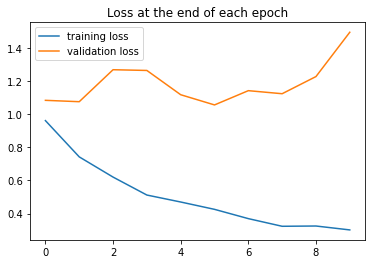

In [13]:
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

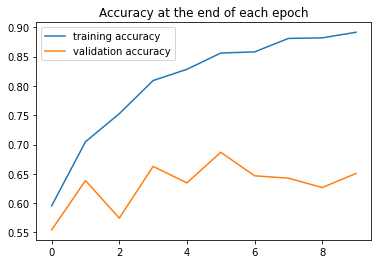

In [14]:
plt.plot(range(epochs),train_correct, label='training accuracy')
plt.plot(range(epochs), val_correct, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Display Metrics and Confusion matrix

In [15]:
def metrics_function(y_predicted, y_probs, y_true):
    '''
    This function takes an input of predictions and true values and returns weighted precision, recall, f1 scores,
    and AUC scores. 
    Inputs:
        y_predicted: NumPy array of shape (n_samples,) which contains predictions of categories
        y_probs: NumPy array of shape (n_samples, n_classes) which contains probabilities for each class
        y_true: NumPy array of shape (n_samples,) which contains actual labels for samples
    Outputs:
        f1_score: Weighted F1-score
        precision: Weighted Precision score
        recall: Weighted recall score
        auc: Weighted AUC score calculated using One-Versus-Rest Approach
        confusion_matrix: Confusion Matrix
    '''
    import sklearn.metrics
    from sklearn.preprocessing import OneHotEncoder
    import numpy as np
    
    params = {
        'y_true': y_true,
        'y_pred': y_predicted,
        'average': 'weighted'
    }
    f1_score = sklearn.metrics.f1_score(**params)
    precision = sklearn.metrics.precision_score(**params)
    recall = sklearn.metrics.recall_score(**params)
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true = y_true, y_pred = y_predicted)
    
    encoder = OneHotEncoder()
    y_encoded = encoder.fit_transform(np.array(y_true).reshape(-1,1))
    auc = sklearn.metrics.roc_auc_score(y_true = y_encoded.toarray(), y_score = y_probs, average='weighted', multi_class = 'ovr')
    
    return f1_score, precision, recall, auc, confusion_matrix


In [16]:
# Track metrics
metrics_pd =pd.DataFrame(columns =['train_f1','train_precision','train_recall', 'train_auc', 
                                   'val_f1','val_precision', 'val_recall', 'val_auc',
                                  'test_f1','test_precision', 'test_recall', 'test_auc'])

**Training Set**

TRAINING SET METRICS
------------------------------------------------------------
Test accuracy:		0.912751677852349
Balanced accuracy:	0.6998057413764306
Classification report:

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       237
           1       0.92      0.97      0.94       667
           2       1.00      0.20      0.33         5
           3       0.83      0.79      0.81       134

    accuracy                           0.91      1043
   macro avg       0.92      0.70      0.74      1043
weighted avg       0.91      0.91      0.91      1043



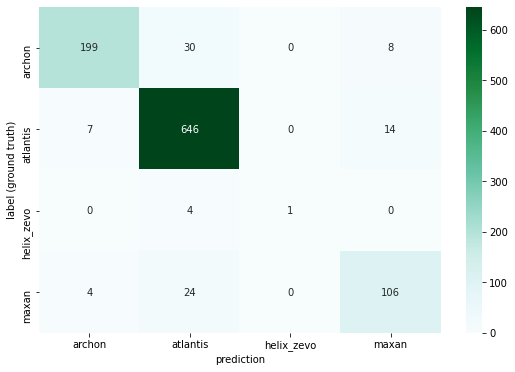

***TRAINING SET***
F1 score is 0.9105276050071041
Precision score is 0.9133295874786767
recall score is 0.912751677852349
auc score is 0.9775142838312417
confusion_matrix score is:
[[  199    30     0     8]
 [    7   646     0    14]
 [    0     4     1     0]
 [    4    24     0   106]]


In [17]:
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=1, shuffle=False)
y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['train']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('TRAINING SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


train_f1_score, train_precision, train_recall, train_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TRAINING SET***")
print(f'F1 score is {train_f1_score}')
print(f'Precision score is {train_precision}')
print(f'recall score is {train_recall}')
print(f'auc score is {train_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

**Validation Set**

VALIDATION SET METRICS
------------------------------------------------------------
Test accuracy:		0.6867469879518072
Balanced accuracy:	0.40324384787472034
Classification report:

              precision    recall  f1-score   support

           0       0.61      0.44      0.51        45
           1       0.73      0.95      0.82       149
           2       0.00      0.00      0.00        10
           3       0.45      0.22      0.30        45

    accuracy                           0.69       249
   macro avg       0.45      0.40      0.41       249
weighted avg       0.63      0.69      0.64       249



/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


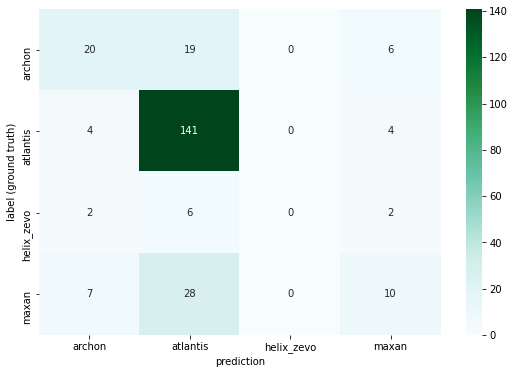

***VALIDATION SET***
F1 score is 0.6385992635492614
Precision score is 0.6265907114869977
recall score is 0.6867469879518072
auc score is 0.8020331485924006
confusion_matrix score is:
[[   20    19     0     6]
 [    4   141     0     4]
 [    2     6     0     2]
 [    7    28     0    10]]


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['val']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('VALIDATION SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])

val_f1_score, val_precision, val_recall, val_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***VALIDATION SET***")
print(f'F1 score is {val_f1_score}')
print(f'Precision score is {val_precision}')
print(f'recall score is {val_recall}')
print(f'auc score is {val_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

**Test Set**

TEST SET METRICS
------------------------------------------------------------
Test accuracy:		0.7421203438395415
Balanced accuracy:	0.36936772226859615
Classification report:

              precision    recall  f1-score   support

           0       0.75      0.43      0.55        83
           1       0.76      0.95      0.84       233
           2       0.00      0.00      0.00        12
           3       0.20      0.10      0.13        21

    accuracy                           0.74       349
   macro avg       0.43      0.37      0.38       349
weighted avg       0.70      0.74      0.70       349



/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


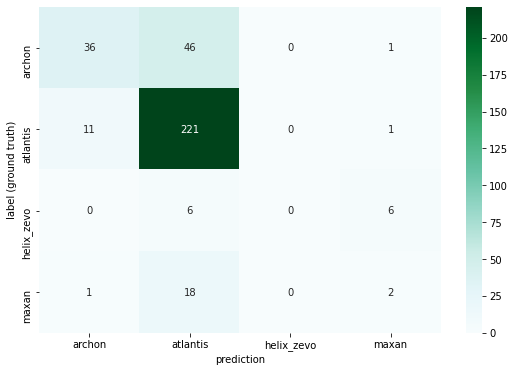

***TEST SET***
F1 score is 0.7016222520600951
Precision score is 0.6974266190096396
recall score is 0.7421203438395415
auc score is 0.7371667878587649
confusion_matrix score is:
[[   36    46     0     1]
 [   11   221     0     1]
 [    0     6     0     6]
 [    1    18     0     2]]


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
test_set = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['test']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        test_set.append(X_test)
        correct += (predicted == y_test).sum()
 
print('TEST SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))
#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


test_f1_score, test_precision, test_recall, test_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TEST SET***")
print(f'F1 score is {test_f1_score}')
print(f'Precision score is {test_precision}')
print(f'recall score is {test_recall}')
print(f'auc score is {test_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

In [20]:
rows = [[train_f1_score,train_precision, train_recall, train_auc, 
         val_f1_score, val_precision, val_recall, val_auc,
        test_f1_score, test_precision, test_recall, test_auc]]
for row in rows:
    metrics_pd.loc[len(metrics_pd)] = row

In [21]:
metrics_pd

,train_f1,train_precision,train_recall,train_auc,val_f1,val_precision,val_recall,val_auc,test_f1,test_precision,test_recall,test_auc
0,0.910528,0.91333,0.912752,0.977514,0.638599,0.626591,0.686747,0.802033,0.701622,0.697427,0.74212,0.737167


## Examine the misses

In [22]:
misses = np.array([])
for i in range(len(pred_list)):
    if pred_list[i] != y_test_list[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

90

[    0     1     2     3     4     5     6     7     8     9]
[    0     1     2     3     4     5     6     7     8     9]
Index: 0 and file name: {('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/data/test/archon/IM-0287-0001.png', 0)}
Label:0 and Prediction: 1


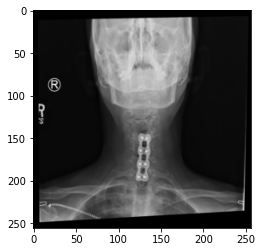

Index: 1 and file name: {('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/data/test/archon/IM-0288-0001.png', 0)}
Label:0 and Prediction: 1


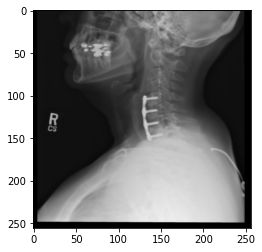

Index: 2 and file name: {('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/data/test/archon/IM-0289-0001.png', 0)}
Label:0 and Prediction: 1


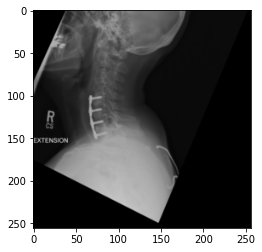

Index: 3 and file name: {('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/data/test/archon/IM-0290-0001.png', 0)}
Label:0 and Prediction: 1


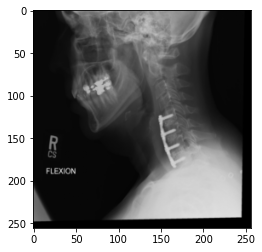

Index: 4 and file name: {('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/data/test/archon/IM-0307-0001.png', 0)}
Label:0 and Prediction: 1


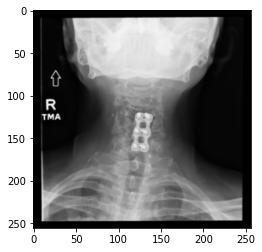

Index: 5 and file name: {('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/data/test/archon/IM-0308-0001.png', 0)}
Label:0 and Prediction: 1


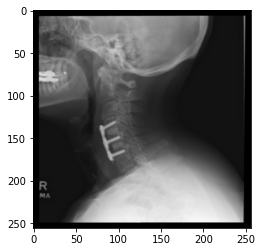

Index: 6 and file name: {('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/data/test/archon/IM-0309-0001.png', 0)}
Label:0 and Prediction: 1


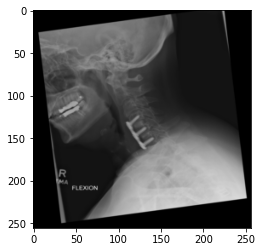

Index: 7 and file name: {('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/data/test/archon/IM-0310-0001.png', 0)}
Label:0 and Prediction: 1


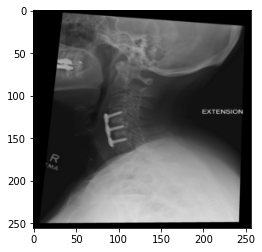

Index: 8 and file name: {('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/data/test/archon/IM-0332-0001.png', 0)}
Label:0 and Prediction: 1


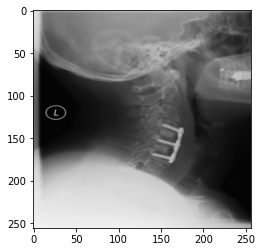

Index: 9 and file name: {('/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/data/test/archon/IM-0333-0001.png', 0)}
Label:0 and Prediction: 1


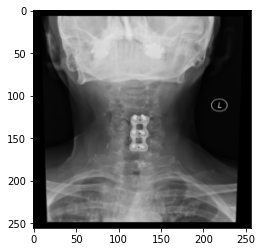

In [23]:
# Display the first 10 index positions

print(misses[:10])
ten_misses =misses[:10]
print(ten_misses)
for i in ten_misses:
    print(f'Index: {i} and file name:', {image_datasets['test'].imgs[i]})
    #nextrow = next(row)
    lbls = y_test_list[i]
    pred = pred_list[i]
    print(f'Label:{lbls} and Prediction: {pred}')

    images = test_set[i].to('cpu')
    im = make_grid(images, nrow=ten_misses)
    plt.figure(figsize=(8,4))
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    plt.show(block=False)

### RUN 2

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam([
    {'params': list(model_ft.parameters())[:-1], 'lr': 1e-7},#, 'momentum': 0.9, 'weight_decay': 1e-4},
    {'params': list(model_ft.parameters())[-1], 'lr':  1e-1}#, 'momentum': 0.9, 'weight_decay': 1e-4}
])

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.003, steps_per_epoch=len(dataloaders['train']), epochs=10)

In [39]:
# Total model parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    #for item in params:
        #print(f'{item:>6}')
    print(f'Total model parameters: {sum(params):>6}')
    
count_parameters(model_ft)

Total model parameters: 21286724


In [40]:
epochs=10
model_ft,train_loss,val_loss, train_correct, val_correct = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=epochs)

Epoch 0/9
----------
train Loss: 0.9761 Acc: 0.6040
val Loss: 1.1346 Acc: 0.5703

Epoch 1/9
----------
train Loss: 0.7488 Acc: 0.6999
val Loss: 1.1266 Acc: 0.6145

Epoch 2/9
----------
train Loss: 0.6349 Acc: 0.7555
val Loss: 1.1370 Acc: 0.6064

Epoch 3/9
----------
train Loss: 0.5142 Acc: 0.8121
val Loss: 1.0829 Acc: 0.6546

Epoch 4/9
----------
train Loss: 0.4532 Acc: 0.8265
val Loss: 1.4596 Acc: 0.5301

Epoch 5/9
----------
train Loss: 0.4403 Acc: 0.8322
val Loss: 1.6043 Acc: 0.6345

Epoch 6/9
----------
train Loss: 0.3942 Acc: 0.8437
val Loss: 1.0263 Acc: 0.6827

Epoch 7/9
----------
train Loss: 0.3111 Acc: 0.8811
val Loss: 1.4100 Acc: 0.6345

Epoch 8/9
----------
train Loss: 0.3218 Acc: 0.8811
val Loss: 1.2684 Acc: 0.6426

Epoch 9/9
----------
train Loss: 0.3115 Acc: 0.8840
val Loss: 1.3425 Acc: 0.6064

Training complete in 12m 0s
Best val Acc: 0.682731


In [41]:
torch.save(model_ft.state_dict(), '/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/Resnet34__anterior_ep10_CEloss_run2.pt')

### Plot the loss and accuracy comparisons

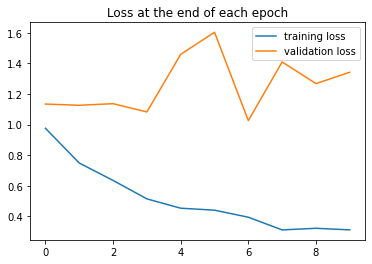

In [42]:
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

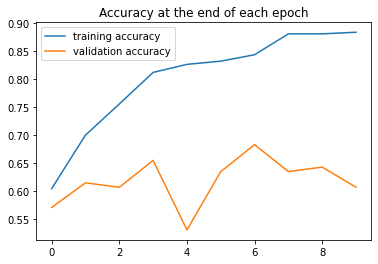

In [43]:
plt.plot(range(epochs),train_correct, label='training accuracy')
plt.plot(range(epochs), val_correct, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

TRAINING SET METRICS
------------------------------------------------------------
Test accuracy:		0.9050814956855225
Balanced accuracy:	0.6565195462914679
Classification report:

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       237
           1       0.92      0.95      0.93       667
           2       0.00      0.00      0.00         5
           3       0.81      0.86      0.83       134

    accuracy                           0.91      1043
   macro avg       0.67      0.66      0.66      1043
weighted avg       0.90      0.91      0.90      1043



/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


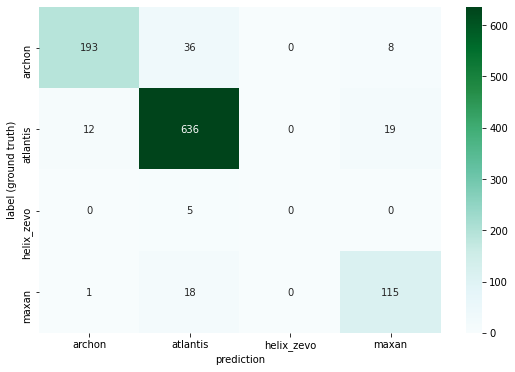

***TRAINING SET***
F1 score is 0.9022985811502233
Precision score is 0.90214937152274
recall score is 0.9050814956855225
auc score is 0.9792416953598533
confusion_matrix score is:
[[  193    36     0     8]
 [   12   636     0    19]
 [    0     5     0     0]
 [    1    18     0   115]]


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=1, shuffle=False)
y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['train']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('TRAINING SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


train_f1_score, train_precision, train_recall, train_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TRAINING SET***")
print(f'F1 score is {train_f1_score}')
print(f'Precision score is {train_precision}')
print(f'recall score is {train_recall}')
print(f'auc score is {train_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

VALIDATION SET METRICS
------------------------------------------------------------
Test accuracy:		0.6827309236947792
Balanced accuracy:	0.4248322147651007
Classification report:

              precision    recall  f1-score   support

           0       0.62      0.44      0.52        45
           1       0.75      0.90      0.82       149
           2       0.00      0.00      0.00        10
           3       0.42      0.36      0.39        45

    accuracy                           0.68       249
   macro avg       0.45      0.42      0.43       249
weighted avg       0.64      0.68      0.65       249



/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


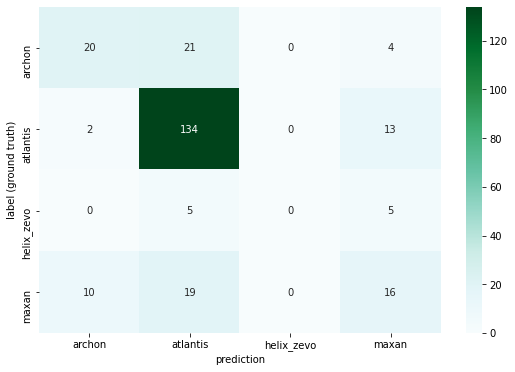

***VALIDATION SET***
F1 score is 0.6524896522329687
Precision score is 0.637005091816841
recall score is 0.6827309236947792
auc score is 0.8170768297572932
confusion_matrix score is:
[[   20    21     0     4]
 [    2   134     0    13]
 [    0     5     0     5]
 [   10    19     0    16]]


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['val']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('VALIDATION SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])

val_f1_score, val_precision, val_recall, val_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***VALIDATION SET***")
print(f'F1 score is {val_f1_score}')
print(f'Precision score is {val_precision}')
print(f'recall score is {val_recall}')
print(f'auc score is {val_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

TEST SET METRICS
------------------------------------------------------------
Test accuracy:		0.7249283667621776
Balanced accuracy:	0.39542535562236686
Classification report:

              precision    recall  f1-score   support

           0       0.78      0.43      0.56        83
           1       0.77      0.91      0.83       233
           2       0.00      0.00      0.00        12
           3       0.19      0.24      0.21        21

    accuracy                           0.72       349
   macro avg       0.44      0.40      0.40       349
weighted avg       0.71      0.72      0.70       349



/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


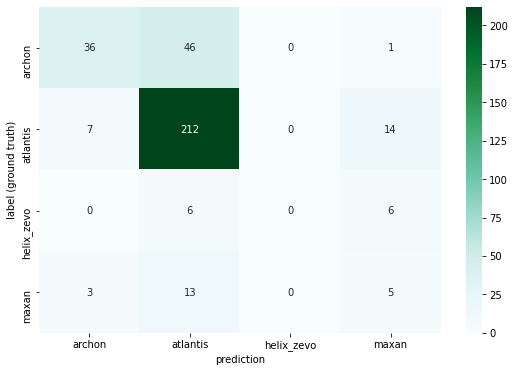

***TEST SET***
F1 score is 0.7005830098088838
Precision score is 0.7086529886099839
recall score is 0.7249283667621776
auc score is 0.7913381875810859
confusion_matrix score is:
[[   36    46     0     1]
 [    7   212     0    14]
 [    0     6     0     6]
 [    3    13     0     5]]


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
test_set = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['test']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        test_set.append(X_test)
        correct += (predicted == y_test).sum()
 
print('TEST SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))
#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


test_f1_score, test_precision, test_recall, test_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TEST SET***")
print(f'F1 score is {test_f1_score}')
print(f'Precision score is {test_precision}')
print(f'recall score is {test_recall}')
print(f'auc score is {test_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

In [48]:
rows = [[train_f1_score,train_precision, train_recall, train_auc, 
         val_f1_score, val_precision, val_recall, val_auc,
        test_f1_score, test_precision, test_recall, test_auc]]
for row in rows:
    metrics_pd.loc[len(metrics_pd)] = row
    
metrics_pd

,train_f1,train_precision,train_recall,train_auc,val_f1,val_precision,val_recall,val_auc,test_f1,test_precision,test_recall,test_auc
0,0.910528,0.913330,0.912752,0.977514,0.638599,0.626591,0.686747,0.802033,0.701622,0.697427,0.742120,0.737167
1,0.902299,0.902149,0.905081,0.979242,0.652490,0.637005,0.682731,0.817077,0.700583,0.708653,0.724928,0.791338


### RUN 3

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam([
    {'params': list(model_ft.parameters())[:-1], 'lr': 1e-7},#, 'momentum': 0.9, 'weight_decay': 1e-4},
    {'params': list(model_ft.parameters())[-1], 'lr':  1e-1}#, 'momentum': 0.9, 'weight_decay': 1e-4}
])

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.003, steps_per_epoch=len(dataloaders['train']), epochs=10)

In [64]:
# Total model parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    #for item in params:
        #print(f'{item:>6}')
    print(f'Total model parameters: {sum(params):>6}')
    
count_parameters(model_ft)

Total model parameters: 21286724


In [65]:
epochs=10
model_ft,train_loss,val_loss, train_correct, val_correct = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=epochs)

Epoch 0/9
----------
train Loss: 0.9419 Acc: 0.6251
val Loss: 0.9888 Acc: 0.6265

Epoch 1/9
----------
train Loss: 0.7129 Acc: 0.7066
val Loss: 1.2046 Acc: 0.6024

Epoch 2/9
----------
train Loss: 0.6349 Acc: 0.7641
val Loss: 1.1889 Acc: 0.5823

Epoch 3/9
----------
train Loss: 0.5101 Acc: 0.8121
val Loss: 0.9644 Acc: 0.6627

Epoch 4/9
----------
train Loss: 0.5253 Acc: 0.8092
val Loss: 1.1259 Acc: 0.6426

Epoch 5/9
----------
train Loss: 0.3927 Acc: 0.8629
val Loss: 1.0875 Acc: 0.6627

Epoch 6/9
----------
train Loss: 0.3640 Acc: 0.8581
val Loss: 1.2745 Acc: 0.6386

Epoch 7/9
----------
train Loss: 0.3605 Acc: 0.8734
val Loss: 1.1131 Acc: 0.6988

Epoch 8/9
----------
train Loss: 0.2883 Acc: 0.8974
val Loss: 1.0839 Acc: 0.6948

Epoch 9/9
----------
train Loss: 0.2643 Acc: 0.9041
val Loss: 0.9209 Acc: 0.7229

Training complete in 12m 7s
Best val Acc: 0.722892


In [66]:
torch.save(model_ft.state_dict(), '/home/judy/devbox/cspine_hardware/CSC2541 - University of Toronto/Miti/Anterior_Posterior/full_data/anterior/Resnet34__anterior_ep10_CEloss_run3.pt')

### Plot the loss and accuracy comparisons

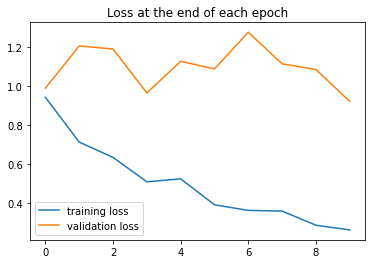

In [67]:
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

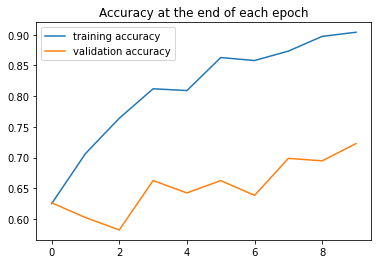

In [68]:
plt.plot(range(epochs),train_correct, label='training accuracy')
plt.plot(range(epochs), val_correct, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

TRAINING SET METRICS
------------------------------------------------------------
Test accuracy:		0.9156279961649089
Balanced accuracy:	0.7355337799643538
Classification report:

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       237
           1       0.96      0.92      0.94       667
           2       0.50      0.20      0.29         5
           3       0.77      0.90      0.83       134

    accuracy                           0.92      1043
   macro avg       0.78      0.74      0.74      1043
weighted avg       0.92      0.92      0.92      1043



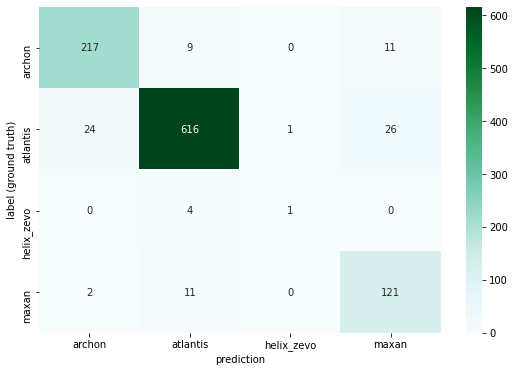

***TRAINING SET***
F1 score is 0.9161037307011213
Precision score is 0.9192231337231054
recall score is 0.9156279961649089
auc score is 0.9859795409503466
confusion_matrix score is:
[[  217     9     0    11]
 [   24   616     1    26]
 [    0     4     1     0]
 [    2    11     0   121]]


In [69]:
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=1, shuffle=False)
y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['train']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('TRAINING SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


train_f1_score, train_precision, train_recall, train_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TRAINING SET***")
print(f'F1 score is {train_f1_score}')
print(f'Precision score is {train_precision}')
print(f'recall score is {train_recall}')
print(f'auc score is {train_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

VALIDATION SET METRICS
------------------------------------------------------------
Test accuracy:		0.7228915662650602
Balanced accuracy:	0.5075316927665922
Classification report:

              precision    recall  f1-score   support

           0       0.59      0.71      0.65        45
           1       0.83      0.85      0.84       149
           2       0.00      0.00      0.00        10
           3       0.50      0.47      0.48        45

    accuracy                           0.72       249
   macro avg       0.48      0.51      0.49       249
weighted avg       0.69      0.72      0.71       249



/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


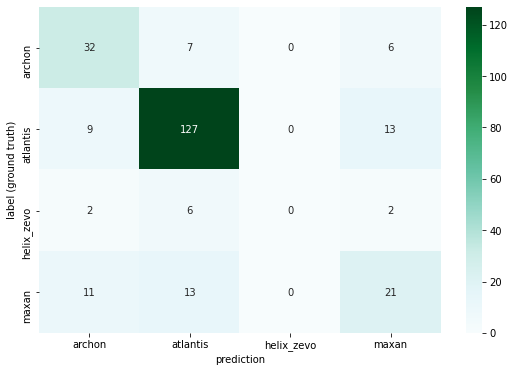

***VALIDATION SET***
F1 score is 0.7073611558901428
Precision score is 0.6941622699950128
recall score is 0.7228915662650602
auc score is 0.8486829556308754
confusion_matrix score is:
[[   32     7     0     6]
 [    9   127     0    13]
 [    2     6     0     2]
 [   11    13     0    21]]


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['val']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        correct += (predicted == y_test).sum()
        
print('VALIDATION SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))

#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])

val_f1_score, val_precision, val_recall, val_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***VALIDATION SET***")
print(f'F1 score is {val_f1_score}')
print(f'Precision score is {val_precision}')
print(f'recall score is {val_recall}')
print(f'auc score is {val_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

TEST SET METRICS
------------------------------------------------------------
Test accuracy:		0.7535816618911175
Balanced accuracy:	0.4255458375500777
Classification report:

              precision    recall  f1-score   support

           0       0.75      0.55      0.64        83
           1       0.80      0.91      0.85       233
           2       0.00      0.00      0.00        12
           3       0.23      0.24      0.23        21

    accuracy                           0.75       349
   macro avg       0.44      0.43      0.43       349
weighted avg       0.73      0.75      0.73       349



/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


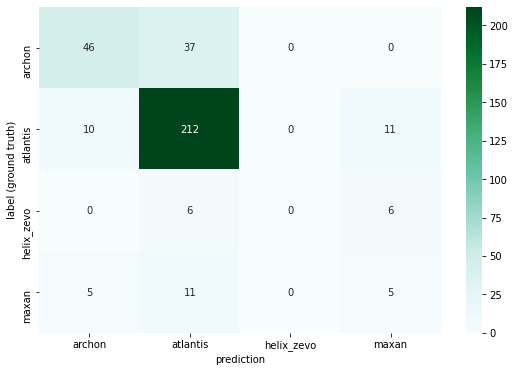

***TEST SET***
F1 score is 0.7332133485038683
Precision score is 0.7251064164110437
recall score is 0.7535816618911175
auc score is 0.8159220986911541
confusion_matrix score is:
[[   46    37     0     0]
 [   10   212     0    11]
 [    0     6     0     6]
 [    5    11     0     5]]


/home/jupyter-utoronto_spine/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=1, shuffle=False)

y_test_list = []
pred_list = []
y_score_list = []
test_set = []
with torch.no_grad():
    correct = 0
    for X_test, y_test in dataloaders['test']:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        y_val = y_val.to(device)
        y_test_list.append(y_test.item())
        y_score_list.append(y_val.to('cpu').numpy())
        predicted = torch.max(y_val,1)[1]
        pred_list.append(predicted.item())
        test_set.append(X_test)
        correct += (predicted == y_test).sum()
 
print('TEST SET METRICS')
print(60*'-')
print(f'Test accuracy:\t\t{accuracy_score(y_test_list, pred_list)}')
print(f'Balanced accuracy:\t{balanced_accuracy_score(y_test_list, pred_list)}')
print('Classification report:\n')
print(classification_report(y_test_list, pred_list))
#Confusion Matrix
arr = sklearn.metrics.confusion_matrix(y_test_list, pred_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

y_test_list= np.asarray(y_test_list)
pred_list = np.asarray(pred_list)
y_score_list = nn.Softmax(dim=-1)(torch.Tensor(y_score_list)).numpy()
y_score_list = y_score_list.reshape(y_score_list.shape[0], y_score_list.shape[2])


test_f1_score, test_precision, test_recall, test_auc, confusion_matrix = metrics_function(pred_list, y_score_list, y_test_list)
print("***TEST SET***")
print(f'F1 score is {test_f1_score}')
print(f'Precision score is {test_precision}')
print(f'recall score is {test_recall}')
print(f'auc score is {test_auc}')
print(f'confusion_matrix score is:')
print(confusion_matrix)

In [72]:
rows = [[train_f1_score,train_precision, train_recall, train_auc, 
         val_f1_score, val_precision, val_recall, val_auc,
        test_f1_score, test_precision, test_recall, test_auc]]
for row in rows:
    metrics_pd.loc[len(metrics_pd)] = row
    
metrics_pd

,train_f1,train_precision,train_recall,train_auc,val_f1,val_precision,val_recall,val_auc,test_f1,test_precision,test_recall,test_auc
0,0.910528,0.913330,0.912752,0.977514,0.638599,0.626591,0.686747,0.802033,0.701622,0.697427,0.742120,0.737167
1,0.902299,0.902149,0.905081,0.979242,0.652490,0.637005,0.682731,0.817077,0.700583,0.708653,0.724928,0.791338
2,0.916104,0.919223,0.915628,0.985980,0.707361,0.694162,0.722892,0.848683,0.733213,0.725106,0.753582,0.815922


### Calculating Final Metrics

In [73]:
metrics_pd.to_csv('anterior_metrics.csv', header=True)

In [74]:
compiled = metrics_pd[['test_f1', 'test_precision', 'test_recall', 'test_auc']]
compiled

,test_f1,test_precision,test_recall,test_auc
0,0.701622,0.697427,0.742120,0.737167
1,0.700583,0.708653,0.724928,0.791338
2,0.733213,0.725106,0.753582,0.815922


In [75]:
# Calculating compiled results
conf_int = compiled.apply(lambda x: st.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=st.sem(x)))
means = compiled.apply(lambda x: np.mean(x))
support = compiled.apply(lambda x: len(x))

In [76]:
# Putting them together
final = pd.concat([means,conf_int, support], axis = 1)
final.columns = ["Mean", "Confidence Intervals", "Support"]

In [54]:
final

,Mean,Confidence Intervals,Support
test_f1,0.701103,"(0.6945002185271686, 0.7077050433418103)",2
test_precision,0.703040,"(0.6317175285153959, 0.7743620791042277)",2
test_recall,0.733524,"(0.6243019650163433, 0.8427467455853759)",2
test_auc,0.764252,"(0.42009603985446975, 1.108408935585381)",2
